In [141]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [142]:
import numpy as np
import pandas as pd
import datetime 
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [143]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import create_engine, func, text, inspect

In [144]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [145]:
# reflect an existing database into a new model
Base = automap_base()

In [146]:
inspector = inspect(engine)
tables = inspector.get_table_names()

print("Tables in the database:")
for table in tables:
    print(table)

Tables in the database:
measurement
station


In [147]:
# reflect the tables
Base.prepare(autoload_with=engine)

In [148]:
# View all of the classes that automap found
print("Classes found in the database:")
for class_name in Base.classes.keys():
    print(class_name)

Classes found in the database:
measurement
station


In [149]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [150]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [151]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [152]:
# Create our session (link) from Python to the DB
Session = sessionmaker(bind=engine)
session = Session()

# Exploratory Precipitation Analysis

In [153]:
# Find the most recent date in the data set.
most_recent = session.query(func.max(measurement.date)).scalar()
most_recent_date = pd.to_datetime(most_recent)
print("Most recent date is:", most_recent_date)

Most recent date is: 2017-08-23 00:00:00


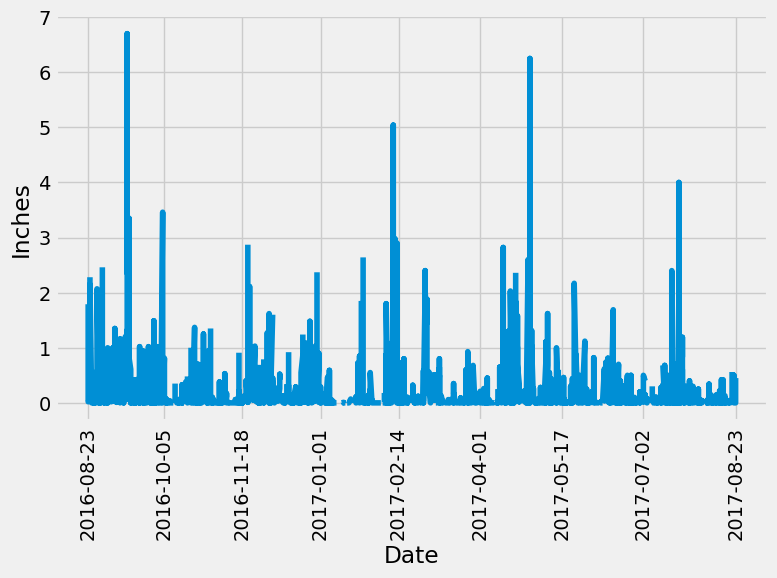

In [154]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
prior = most_recent_date - relativedelta(months=12)
prior_twelve = prior.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).filter(measurement.date >= prior_twelve).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
data = pd.DataFrame(results, columns=['date', 'precipitation'])

# Sort the dataframe by date
sorted_data = data.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(8, 6))
plt.plot(sorted_data['date'], sorted_data['precipitation'])
plt.xlabel('Date')
plt.ylabel('Inches')  # Adjust units as necessary
num_xticks = 9
tick_indices = np.linspace(0, len(sorted_data['date']) - 1, num_xticks, dtype=int)
plt.xticks(sorted_data['date'].iloc[tick_indices], rotation=90)
plt.tight_layout()
plt.grid(visible=True, linestyle='-', linewidth=1.0)
plt.show()

In [155]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = sorted_data['precipitation'].describe()
summary_stats


count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [156]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.id)).scalar()
total_stations

9

In [160]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = (
    session.query(
        measurement.station,
        func.count(measurement.id)
        )
        .group_by(measurement.station)
        .order_by(func.count(measurement.id)
        .desc())
        .all()
)

for station, count in most_active_stations:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [163]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = 'USC00519281'
temperature_stats = (
    session.query(
        func.min(measurement.tobs),
        func.max(measurement.tobs),
        func.avg(measurement.tobs)
    )
    .filter(measurement.station == most_active_station_id)
    .all()
)

# Extract and display the results
lowest_temp, highest_temp, avg_temp = temperature_stats[0] 

print(f"Station: {most_active_station_id}")
print(f"Lowest Temperature: {lowest_temp} °F")
print(f"Highest Temperature: {highest_temp} °F")
print(f"Average Temperature: {avg_temp:.2f} °F")

Station: USC00519281
Lowest Temperature: 54.0 °F
Highest Temperature: 85.0 °F
Average Temperature: 71.66 °F


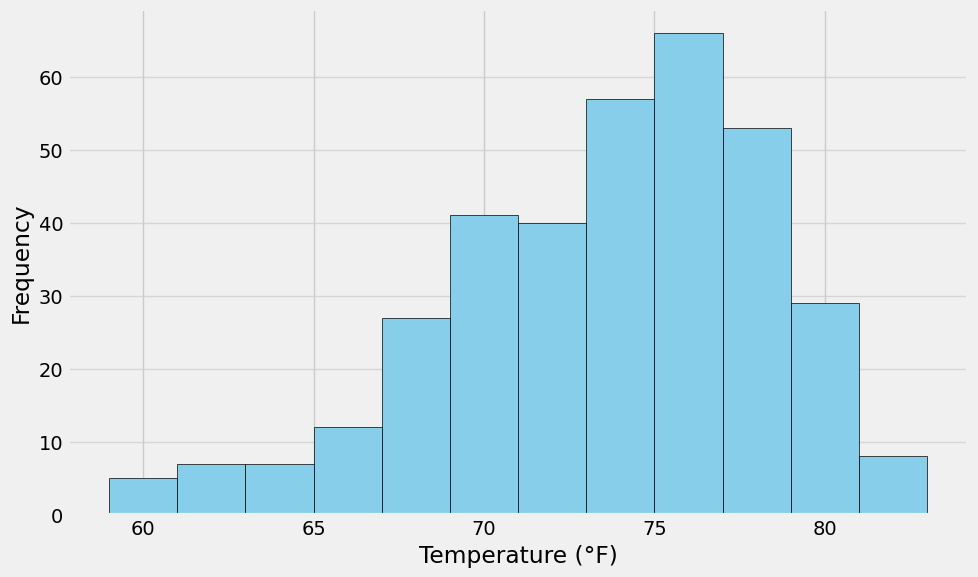

In [172]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = (
    session.query(measurement.tobs)
    .filter(measurement.station == most_active_station_id)
    .filter(measurement.date >= prior_twelve)
    .all()
)

temps = [temp[0] for temp in temperature_data]

plt.figure(figsize=(10, 6))
plt.hist(temps, bins=12, color='skyblue', edgecolor='black')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='-', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

# Close Session

In [173]:
# Close Session
session.close()